## Diffusion Model - The Intuition

* The literal meaning of the word Diffusion is the net movement of anything (for example, atoms, ions, molecules, energy) generally from **a region of higher concentration to a region of lower concentration**.

* In our context, Diffusion is the **gradual movement** of a sample (for example, image) from a **Simple Probability Distribution to a Complex Probability Distribution or vice versa**.

* You can consider Distribution over images of Cat/Dog/Church, etc a Complex Distribution and Noisy Zibberish Image drawn from a Normal Distibution 𝑁(0 ,1) as a Simple Distribution.

* In Simple words, Diffusion model learns **how to transform a Normal Distribution into a Complex Distribution.** i.e. Mapping; Simple --> Complex Distribution

* Once this mapping is learnt, you can simply draw the samples from a Normal Distribution and generate the images of Cat/Dog/Church, etc by mapping it to the learnt Complex Distribution. 

Our goal is to learn this mapping of a Simple Distribution to the Complex Image Distribution.

## Diffusion Model - The Structure

We can break down the process of Diffusion Model into two parts.

    1. Forward Process
    2. Reverse Process

In [1]:
# Imports
import torch
import torch.nn as nn

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')
    

Device: cpu



In [3]:
class DiffusionForwardProcess:
    
    r"""
    
    Forward Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        
        r""" Adds noise to a batch of original images at time-step t.
        
        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )
        
        Note: time-step t may differ for each image inside the batch.
        
        """
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)

In [4]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,)) 

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

In [5]:
class DiffusionReverseProcess:
    
    r"""
    
    Reverse Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        
        r""" Sample x_(t-1) given x_t and noise predicted
             by model.
             
             :param xt: Image tensor at timestep t of shape -> B x C x H x W
             :param noise_pred: Noise Predicted by model of shape -> B x C x H x W
             :param t: Current time step

        """
        
        # Original Image Prediction at timestep t
        x0 = xt - (torch.sqrt(1 - self.a_bar.to(xt.device)[t]) * noise_pred)
        x0 = x0/torch.sqrt(self.a_bar.to(xt.device)[t])
        x0 = torch.clamp(x0, -1., 1.) 
        
        # mean of x_(t-1)
        mean = (xt - ((1 - self.a.to(xt.device)[t]) * noise_pred)/(torch.sqrt(1 - self.a_bar.to(xt.device)[t])))
        mean = mean/(torch.sqrt(self.a.to(xt.device)[t]))
        
        # only return mean
        if t == 0:
            return mean, x0
        
        else:
            variance =  (1 - self.a_bar.to(xt.device)[t-1])/(1 - self.a_bar.to(xt.device)[t])
            variance = variance * self.b.to(xt.device)[t]
            sigma = variance**0.5
            z = torch.randn(xt.shape).to(xt.device)
            
            return mean + sigma * z, x0

In [6]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,)) 

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])

## Model Architecture

* In the paper, author uses **U-net** architecture to predict the noise.
* U-net takes noisy image at time-step T and time-step T as input and returns the predicted noise which will be used to predict *x<sub>t-1</sub>* and *x<sub>0</sub>*.

Let's implement modules required for U-net.

### Time Embedding

* In Diffusion model, Time information is important. The model needs to be aware of the specific time step at which it is predicting noise.

* The idea to embed the time information is taken from the positional time embedding used in the Transformers. The time embedding is done using below formula. **d_embed** is the embedding dimension.

$$ PE(pos, 0:d_{\text{embed}}/2) = \sin\left(\frac{pos}{10000^{2i/d_{\text{embed}}}}\right) $$

$$ PE(pos, d_{\text{embed}}/2:d_{\text{embed}}) = \cos\left(\frac{pos}{10000^{2i/d_{\text{embed}}}}\right) $$

Let's implement the Time Embedding Layer.


In [7]:
def get_time_embedding(
    time_steps: torch.Tensor,
    t_emb_dim: int
) -> torch.Tensor:
    
    """ 
    Transform a scalar time-step into a vector representation of size t_emb_dim.
    
    :param time_steps: 1D tensor of size -> (Batch,)
    :param t_emb_dim: Embedding Dimension -> for ex: 128 (scalar value)
    
    :return tensor of size -> (B, t_emb_dim)
    """
    
    assert t_emb_dim%2 == 0, "time embedding must be divisible by 2."
    
    factor = 2 * torch.arange(start = 0, 
                              end = t_emb_dim//2, 
                              dtype=torch.float32, 
                              device=time_steps.device
                             ) / (t_emb_dim)
    
    factor = 10000**factor

    t_emb = time_steps[:,None] # B -> (B, 1) 
    t_emb = t_emb/factor # (B, 1) -> (B, t_emb_dim//2)
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=1) # (B , t_emb_dim)
    
    return t_emb

### U-net

* Diffusion Model predicts the amount of noise given noisy image at different time-steps.

* Note that Input and Output both are **2-Dimensional images**, Hence U-net type architecture is suitable for this task.

* The U-net architecture begins by taking an image as input. It then proceeds to extract features while downsampling, followed by refining these downsampled features. Finally, it upsamples the refined features to reconstruct an image of the same size as the output.

* U-net architecture consists of 3 main blocks.
    1. Down-Convolutional Block
    2. Mid-Conv Block
    3. Up-Conv block
    
    
    
* A typical U-net block looks something like this.

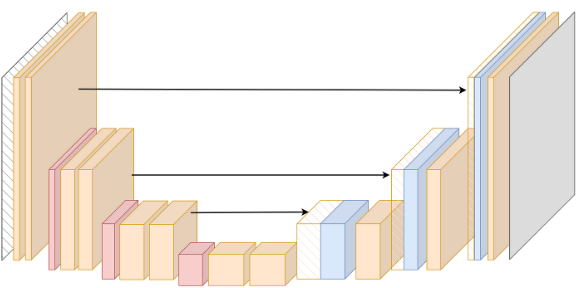

**Utility Modules**

In [8]:
class NormActConv(nn.Module):
    """
    Perform GroupNorm, Activation, and Convolution operations.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 num_groups:int = 8, 
                 kernel_size: int = 3, 
                 norm:bool = True,
                 act:bool = True
                ):
        super(NormActConv, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            in_channels
        ) if norm is True else nn.Identity()
        
        # Activation
        self.act = nn.SiLU() if act is True else nn.Identity()
        
        # Convolution
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size, 
            padding=(kernel_size - 1)//2
        )
        
    def forward(self, x):
        x = self.g_norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x
    
#-----------------------------------------------------------------

class TimeEmbedding(nn.Module):
    """
    Maps the Time Embedding to the Required output Dimension.
    """
    def __init__(self, 
                 n_out:int, # Output Dimension
                 t_emb_dim:int = 128 # Time Embedding Dimension
                ):
        super(TimeEmbedding, self).__init__()
        
        # Time Embedding Block
        self.te_block = nn.Sequential(
            nn.SiLU(), 
            nn.Linear(t_emb_dim, n_out)
        )
        
    def forward(self, x):
        return self.te_block(x)
    
#---------------------------------------------------------------

class SelfAttentionBlock(nn.Module):
    """
    Perform GroupNorm and Multiheaded Self Attention operation.    
    """
    def __init__(self, 
                 num_channels:int,
                 num_groups:int = 8, 
                 num_heads:int = 4,
                 norm:bool = True
                ):
        super(SelfAttentionBlock, self).__init__()
        
        # GroupNorm
        self.g_norm = nn.GroupNorm(
            num_groups,
            num_channels
        ) if norm is True else nn.Identity()
        
        # Self-Attention
        self.attn = nn.MultiheadAttention(
            num_channels,
            num_heads, 
            batch_first=True
        )
        
    def forward(self, x):
        batch_size, channels, h, w = x.shape
        x = x.reshape(batch_size, channels, h*w)
        x = self.g_norm(x)
        x = x.transpose(1, 2)
        x, _ = self.attn(x, x, x)
        x = x.transpose(1, 2).reshape(batch_size, channels, h, w)
        return x
    
#----------------------------------------------------------------

class Downsample(nn.Module):
    """
    Perform Downsampling by the factor of k across Height and Width.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Downsampling factor
                 use_conv:bool = True, # If Downsampling using conv-block
                 use_mpool:bool = True # If Downsampling using max-pool
                ):
        super(Downsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_mpool = use_mpool
        
        # Downsampling using Convolution
        self.cv = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=1), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_mpool else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            )
        ) if use_conv else nn.Identity()
        
        # Downsampling using Maxpool
        self.mpool = nn.Sequential(
            nn.MaxPool2d(k, k), 
            nn.Conv2d(
                in_channels, 
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_mpool else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.mpool(x)
        
        if not self.use_mpool:
            return self.cv(x)
            
        return torch.cat([self.cv(x), self.mpool(x)], dim=1)
    
#-----------------------------------------------------------------------

class Upsample(nn.Module):
    """
    Perform Upsampling by the factor of k across Height and Width
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 k:int = 2, # Upsampling factor
                 use_conv:bool = True, # Upsampling using conv-block
                 use_upsample:bool = True # Upsampling using nn.upsample
                ):
        super(Upsample, self).__init__()
        
        self.use_conv = use_conv
        self.use_upsample = use_upsample
        
        # Upsampling using conv
        self.cv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels//2 if use_upsample else out_channels, 
                kernel_size=4, 
                stride=k, 
                padding=1
            ),
            nn.Conv2d(
                out_channels//2 if use_upsample else out_channels, 
                out_channels//2 if use_upsample else out_channels, 
                kernel_size = 1, 
                stride=1, 
                padding=0
            )
        ) if use_conv else nn.Identity()
        
        # Upsamling using nn.Upsample
        self.up = nn.Sequential(
            nn.Upsample(
                scale_factor=k, 
                mode = 'bilinear', 
                align_corners=False
            ),
            nn.Conv2d(
                in_channels,
                out_channels//2 if use_conv else out_channels, 
                kernel_size=1, 
                stride=1, 
                padding=0
            )
        ) if use_upsample else nn.Identity()
        
    def forward(self, x):
        
        if not self.use_conv:
            return self.up(x)
        
        if not self.use_upsample:
            return self.cv(x)
        
        return torch.cat([self.cv(x), self.up(x)], dim=1)

In [9]:
layer = Upsample(16, 32, 2, True, True)
x = torch.randn(4, 16, 32, 32)
layer(x).shape

torch.Size([4, 32, 64, 64])

**Down-Conv Block**

* [Image Reference](https://www.youtube.com/watch?v=vu6eKteJWew&t=330s)

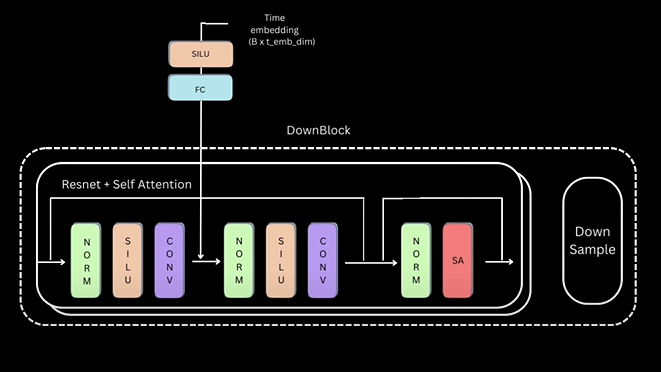

In [10]:
class DownC(nn.Module):
    """
    Perform Down-convolution on the input using following approach.
    1. Conv + TimeEmbedding
    2. Conv
    3. Skip-connection from input x.
    4. Self-Attention
    5. Skip-Connection from 3.
    6. Downsampling
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int=2,
                 down_sample:bool = True # True for Downsampling
                ):
        super(DownC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.down_block =Downsample(out_channels, out_channels) if down_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, t_emb):
        
        out = x
        
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn

        # Downsampling
        out = self.down_block(out)
        
        return out

**Mid-Conv Block**

* [Image Reference](https://www.youtube.com/watch?v=vu6eKteJWew&t=330s)

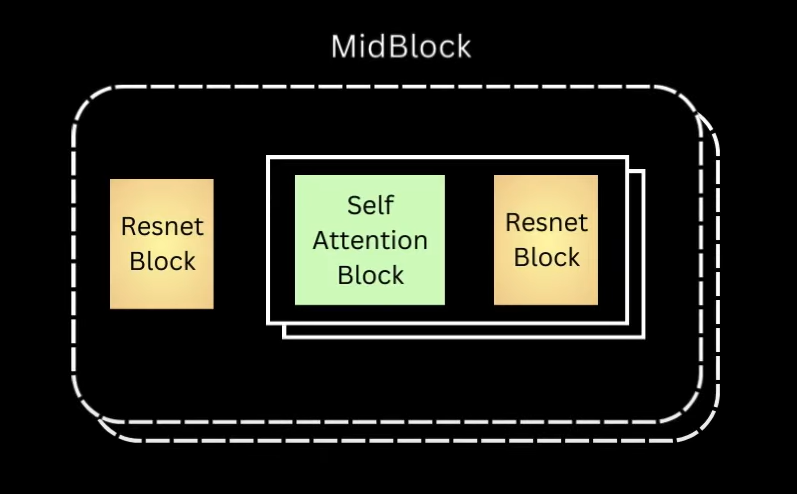

In [11]:
class MidC(nn.Module):
    """
    Refine the features obtained from the DownC block.
    It refines the features using following operations:
    
    1. Resnet Block with Time Embedding
    2. A Series of Self-Attention + Resnet Block with Time-Embedding 
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int,
                 t_emb_dim:int = 128,
                 num_layers:int = 2
                ):
        super(MidC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers + 1)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers + 1)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers + 1)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers + 1)
        ])
        
    def forward(self, x, t_emb):
        out = x
        
        # First-Resnet Block
        resnet_input = out
        out = self.conv1[0](out)
        out = out + self.te_block[0](t_emb)[:, :, None, None]
        out = self.conv2[0](out)
        out = out + self.res_block[0](resnet_input)
        
        # Sequence of Self-Attention + Resnet Blocks
        for i in range(self.num_layers):
            
            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
            
            # Resnet Block
            resnet_input = out
            out = self.conv1[i+1](out)
            out = out + self.te_block[i+1](t_emb)[:, :, None, None]
            out = self.conv2[i+1](out)
            out = out + self.res_block[i+1](resnet_input)
            
        return out

**Up-Conv Block**

* Exactly same as DownC Block except Downsampling block is replaced by Upsampling.

In [12]:
class UpC(nn.Module):
    """
    Perform Up-convolution on the input using following approach.
    1. Upsampling
    2. Conv + TimeEmbedding
    3. Conv
    4. Skip-connection from 1.
    5. Self-Attention
    6. Skip-Connection from 3.
    """
    def __init__(self, 
                 in_channels:int, 
                 out_channels:int, 
                 t_emb_dim:int = 128, # Time Embedding Dimension
                 num_layers:int = 2,
                 up_sample:bool = True # True for Upsampling
                ):
        super(UpC, self).__init__()
        
        self.num_layers = num_layers
        
        self.conv1 = nn.ModuleList([
            NormActConv(in_channels if i==0 else out_channels, 
                        out_channels
                       ) for i in range(num_layers)
        ])
        
        self.conv2 = nn.ModuleList([
            NormActConv(out_channels, 
                        out_channels
                       ) for _ in range(num_layers)
        ])
        
        self.te_block = nn.ModuleList([
            TimeEmbedding(out_channels, t_emb_dim) for _ in range(num_layers)
        ])
        
        self.attn_block = nn.ModuleList([
            SelfAttentionBlock(out_channels) for _ in range(num_layers)
        ])
        
        self.up_block =Upsample(in_channels, in_channels//2) if up_sample else nn.Identity()
        
        self.res_block = nn.ModuleList([
            nn.Conv2d(
                in_channels if i==0 else out_channels, 
                out_channels, 
                kernel_size=1
            ) for i in range(num_layers)
        ])
        
    def forward(self, x, down_out, t_emb):
        
        # Upsampling
        x = self.up_block(x)
        x = torch.cat([x, down_out], dim=1)
        
        out = x
        for i in range(self.num_layers):
            resnet_input = out
            
            # Resnet Block
            out = self.conv1[i](out)
            out = out + self.te_block[i](t_emb)[:, :, None, None]
            out = self.conv2[i](out)
            out = out + self.res_block[i](resnet_input)

            # Self Attention
            out_attn = self.attn_block[i](out)
            out = out + out_attn
        
        return out

**U-net**

* Let's put DownC, MidC, and UpC together to obtain the U-net.

In [13]:
class Unet(nn.Module):
    """
    U-net architecture which is used to predict noise
    in the paper "Denoising Diffusion Probabilistic Model".
    
    U-net consists of Series of DownC blocks followed by MidC
    followed by UpC.
    """
    
    def __init__(self,
                 im_channels: int = 3, # RGB 
                 down_ch: list = [32, 64, 128, 256],
                 mid_ch: list = [256, 256, 128],
                 up_ch: list[int] = [256, 128, 64, 16],
                 down_sample: list[bool] = [True, True, False],
                 t_emb_dim: int = 128,
                 num_downc_layers:int = 2, 
                 num_midc_layers:int = 2, 
                 num_upc_layers:int = 2
                ):
        super(Unet, self).__init__()
        
        self.im_channels = im_channels
        self.down_ch = down_ch
        self.mid_ch = mid_ch
        self.up_ch = up_ch
        self.t_emb_dim = t_emb_dim
        self.down_sample = down_sample
        self.num_downc_layers = num_downc_layers
        self.num_midc_layers = num_midc_layers
        self.num_upc_layers = num_upc_layers
        
        self.up_sample = list(reversed(self.down_sample)) # [False, True, True]
        
        # Initial Convolution
        self.cv1 = nn.Conv2d(self.im_channels, self.down_ch[0], kernel_size=3, padding=1)
        
        # Initial Time Embedding Projection
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim), 
            nn.SiLU(), 
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        # DownC Blocks
        self.downs = nn.ModuleList([
            DownC(
                self.down_ch[i], 
                self.down_ch[i+1], 
                self.t_emb_dim, 
                self.num_downc_layers, 
                self.down_sample[i]
            ) for i in range(len(self.down_ch) - 1)
        ])
        
        # MidC Block
        self.mids = nn.ModuleList([
            MidC(
                self.mid_ch[i], 
                self.mid_ch[i+1], 
                self.t_emb_dim, 
                self.num_midc_layers
            ) for i in range(len(self.mid_ch) - 1)
        ])
        
        # UpC Block
        self.ups = nn.ModuleList([
            UpC(
                self.up_ch[i], 
                self.up_ch[i+1], 
                self.t_emb_dim, 
                self.num_upc_layers, 
                self.up_sample[i]
            ) for i in range(len(self.up_ch) - 1)
        ])
        
        # Final Convolution
        self.cv2 = nn.Sequential(
            nn.GroupNorm(8, self.up_ch[-1]), 
            nn.Conv2d(self.up_ch[-1], self.im_channels, kernel_size=3, padding=1)
        )
        
    def forward(self, x, t):
        
        out = self.cv1(x)
        
        # Time Projection
        t_emb = get_time_embedding(t, self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        # DownC outputs
        down_outs = []
        
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)
        
        # MidC outputs
        for mid in self.mids:
            out = mid(out, t_emb)
        
        # UpC Blocks
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            
        # Final Conv
        out = self.cv2(out)
        
        return out

In [14]:
# Test
model = Unet()
x = torch.randn(4, 3, 32, 32)# _,in_channels,_,_
t = torch.randint(0, 10, (4,))
model(x, t).shape

torch.Size([4, 3, 32, 32])

## Training

**Dataset**

In [15]:
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data.dataset import Dataset
'''
class CustomMnistDataset(Dataset):
    """
    Reads the MNIST data from csv file given file path.
    """
    def __init__(self, csv_path, num_datapoints = None):
        super(CustomMnistDataset, self).__init__()
        
        self.df = pd.read_csv(csv_path)
        
        # Will be useful later while evaluating
        if num_datapoints is not None:
            self.df = self.df.iloc[0:num_datapoints]
      
    def __len__(self):
        return len(self.df)
    
    def  __getitem__(self, index):
        # Read
        img = self.df.iloc[index].filter(regex='pixel').values
        img =  np.reshape(img, (28, 28)).astype(np.uint8)
        
        # Convert to Tensor
        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]
        img_tensor = 2*img_tensor - 1 # [-1, 1]
        
        return img_tensor
        '''

'\nclass CustomMnistDataset(Dataset):\n    """\n    Reads the MNIST data from csv file given file path.\n    """\n    def __init__(self, csv_path, num_datapoints = None):\n        super(CustomMnistDataset, self).__init__()\n        \n        self.df = pd.read_csv(csv_path)\n        \n        # Will be useful later while evaluating\n        if num_datapoints is not None:\n            self.df = self.df.iloc[0:num_datapoints]\n      \n    def __len__(self):\n        return len(self.df)\n    \n    def  __getitem__(self, index):\n        # Read\n        img = self.df.iloc[index].filter(regex=\'pixel\').values\n        img =  np.reshape(img, (28, 28)).astype(np.uint8)\n        \n        # Convert to Tensor\n        img_tensor = torchvision.transforms.ToTensor()(img) # [0, 1]\n        img_tensor = 2*img_tensor - 1 # [-1, 1]\n        \n        return img_tensor\n        '

**Training-Loop**

In [ ]:
class CONFIG:
    #model_path = 'ddpm_unet.pth'
    #train_csv_path = '/kaggle/input/digit-recognizer/train.csv'
    #test_csv_path = '/kaggle/input/digit-recognizer/test.csv'
    #generated_csv_path = 'mnist_generated_data.csv'
    num_epochs = 1 #erstmal 1 zum testen
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 96
    img_size = 32 #28 funktioniert auf jeden Fall
    in_channels = 3
    num_img_to_generate = 8

In [18]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.utils.data import Subset
import torchvision.transforms as transforms

def get_dataloader(cfg):
    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),  # fixed H,W
        transforms.ToTensor()
    ])
    ds = torchvision.datasets.GTSRB(root='./data', split='train', transform=transform, download=True)
    
    target_classes = [0,1,2,3,4,5,6,7,8]#0-9: Geschwindigkeitsbegrenzung, 14: Stoppschild

    #indices = [i for i, label in enumerate(ds._labels) if label == target_class]
    labels = [ds[i][1] for i in range(len(ds))]
    indices = [i for i, label in enumerate(labels) if label in target_classes]

    subset = Subset(ds, indices)
    dl = DataLoader(subset, cfg.batch_size, shuffle=True)
    
    return dl

In [19]:
import matplotlib.pyplot as plt

def print_train_img(dataloader):
    images, labels = next(iter(dataloader))

    # zeige die ersten 8
    for i in range(8):
        img = images[i].permute(1,2,0)   # (C,H,W) → (H,W,C)
        plt.subplot(2,4,i+1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')

    plt.show()

In [20]:


def train(cfg,dl):
    
    '''
    # Dataset and Dataloader
    #mnist_ds = CustomMnistDataset(cfg.train_csv_path)
    #mnist_ds = torchvision.datasets.MNIST("./", train=True, transform=torchvision.transforms.ToTensor(), download=True)
    ds = torchvision.datasets.GTSRB(root='./data', split='train', transform=torchvision.transforms.ToTensor(), download=True)
    
    target_class = 14 #hier stopschilder

    indices = [i for i, label in enumerate(ds.targets) if label == target_class]

    subset = Subset(ds, indices)
    dl = DataLoader(subset, cfg.batch_size, shuffle=True)
    '''
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')
    
    # Initiate Model
    model = Unet().to(device)
    
    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()
    
    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()
    
    # Best Loss
    best_eval_loss = float('inf')
    
    # Train
    for epoch in range(cfg.num_epochs):
        
        # For Loss Tracking
        losses = []
        
        # Set model to train mode
        model.train()
        
        # Loop over dataloader
        for imgs,_ in tqdm(dl):
            
            imgs = imgs.to(device)
            
            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)
            
            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)
            
            # Avoid Gradient Accumulation
            optimizer.zero_grad()
            
            # Predict noise using U-net Model
            noise_pred = model(noisy_imgs, t)
            
            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())
            
            # Backprop + Update model params
            loss.backward()
            optimizer.step()
        
        # Mean Loss
        mean_epoch_loss = np.mean(losses)
        
        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))
        
        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            #torch.save(model, cfg.model_path)
            best_model = model
            
    print(f'Done training.....')
    return best_model

In [25]:
#config
cfg = CONFIG()

In [22]:
#dataloader
dataloader = get_dataloader(cfg) 

100%|██████████| 187M/187M [00:06<00:00, 30.5MB/s] 


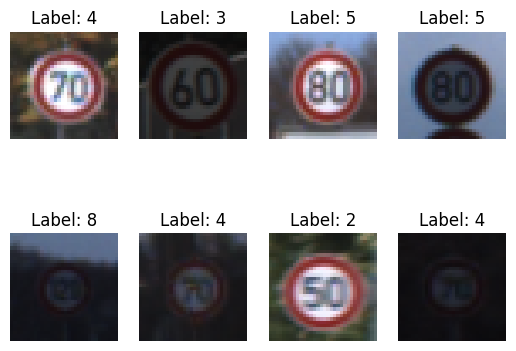

In [23]:
#print some training images
print_train_img(dataloader)

In [26]:
# TRAIN
trained_model=train(cfg,dataloader)

Device: cpu



  0%|          | 0/93 [00:00<?, ?it/s]

: 

: 

: 

## Image Generation/Inference

In [ ]:
def generate(cfg):
    """
    Given Pretrained DDPM U-net model, Generate Real-life
    Images from noise by going backward step by step. i.e.,
    Mapping of Random Noise to Real-life images.
    """
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print(f'Device: {device}\n')
    
    # Initialize Diffusion Reverse Process
    drp = DiffusionReverseProcess()
    
    # Set model to eval mode
    #model = torch.load(cfg.model_path).to(device)
    model = trained_model.to(device)
    model.eval()
    
    # Generate Noise sample from N(0, 1)
    xt = torch.randn(1, cfg.in_channels, cfg.img_size, cfg.img_size).to(device)
    
    # Denoise step by step by going backward.
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
            xt, x0 = drp.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))

    # Convert the image to proper scale
    xt = torch.clamp(xt, -1., 1.).detach().cpu()
    xt = (xt + 1) / 2
    
    return xt

100%|██████████| 8/8 [02:22<00:00, 17.75s/it]


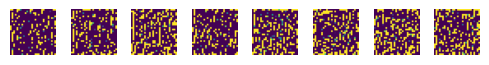

In [ ]:
# Load model and config
cfg = CONFIG()

# Generate
generated_imgs = []
for i in tqdm(range(cfg.num_img_to_generate)):
    xt = generate(cfg)
    xt = 255 * xt[0][0].numpy()
    generated_imgs.append(xt.astype(np.uint8).flatten())

# Save Generated Data CSV
#generated_df = pd.DataFrame(generated_imgs, columns=[f'pixel{i}' for i in range(784)])
#generated_df.to_csv(cfg.generated_csv_path, index=False)

# Visualize
from matplotlib import pyplot as plt
fig, axes = plt.subplots(int(cfg.num_img_to_generate/8), 8, figsize=(5, 2))

# Plot each image in the corresponding subplot
for i, ax in enumerate(axes.flat):
    ax.imshow(np.reshape(generated_imgs[i], (28, 28)))  # You might need to adjust the colormap based on your images
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

# Output Vergleich

Output für 5 Epochen mit 1000 timesteps auf Mnist

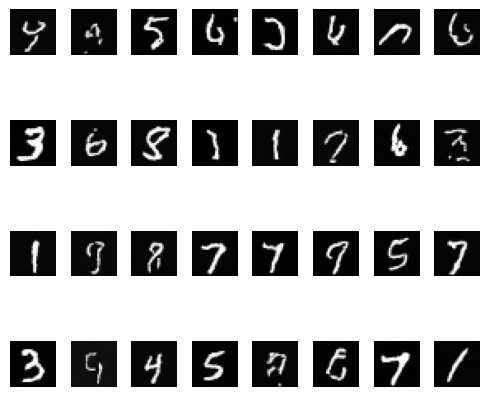

Output für 5 Epochen mit 100 timesteps auf Mnist

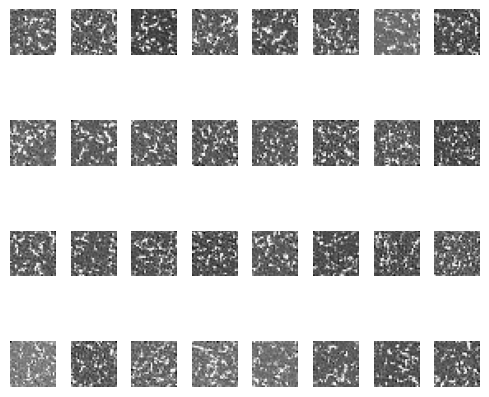

Output für 50 Epochen mit 1000 timesteps auf GTSRB

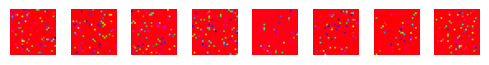

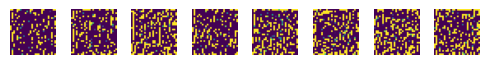

# Loss Vergleich

Zum Vergleich: bei Mnist war der beste loss bei 0.0824 nach 5 Epochen. Bei GTSRB mit nur STopschildern war der loss bei 0.0930 nach 50 Epochen, die Bilder bei GTSRB sind dennoch nicht verwendbar, trotz vergleichbarem loss.

## References

1. [ExplainingAI Implementation GitHub](https://github.com/explainingai-code/DDPM-Pytorch/tree/main)
2. [ExplainingAI Video Tutorial](https://www.youtube.com/watch?v=vu6eKteJWew&t=330s)
3. [Original Implementation GitHub](https://github.com/hojonathanho/diffusion/tree/master)
4. [DDPM Theory](https://github.com/Cranjis-McB/Diffusion-Models/blob/main/Denoising%20Diffusion%20Probabilistic%20Models/theory/theory.ipynb)
